In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import numpy as np
import re

In [2]:
def handle_arabic(input_string):
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)


In [3]:
BART_results_Masc = pd.read_csv("../../German_LMs/encoder_decoder/German_BART/Germany_SOS_Male_BART.csv")
BART_results_Femm = pd.read_csv("../../German_LMs/encoder_decoder/German_BART/Germany_SOS_Female_BART.csv")
BART_results_NB = pd.read_csv("../../German_LMs/encoder_decoder/German_BART/Germany_SOS_Non_Binary_BART.csv")

BERT_results_Masc = pd.read_csv("../../German_LMs/Encoder_only/German_BERT/Germany_SOS_Male_BERT.csv")
BERT_results_Femm = pd.read_csv("../../German_LMs/Encoder_only/German_BERT/Germany_SOS_Female_BERT.csv")
BERT_results_NB = pd.read_csv("../../German_LMs/Encoder_only/German_BERT/Germany_SOS_Non_Binary_BERT.csv")

XLM_RoBERTa_German_results_Masc = pd.read_csv("../../German_LMs/Encoder_only/XLM_RoBERTa_German/Germany_SOS_Male_XLM_Roberta.csv")
XLM_RoBERTa_German_results_Femm = pd.read_csv("../../German_LMs/Encoder_only/XLM_RoBERTa_German/Germany_SOS_Female_XLM_Roberta.csv")
XLM_RoBERTa_German_results_NB = pd.read_csv("../../German_LMs/Encoder_only/XLM_RoBERTa_German/Germany_SOS_Non_Binary_XLM_Roberta.csv")

XML_Roberta_results_Masc = pd.read_csv("../../German_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/Germany_SOS_Male_XLM_Muluilingual.csv")
XML_Roberta_results_Femm = pd.read_csv("../../German_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/Germany_SOS_Female_XLM_Muluilingual.csv")
XML_Roberta_results_NB = pd.read_csv("../../German_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/Germany_SOS_non_Binary_XLM_Muluilingual.csv")

German_Englsih_identities = pd.read_csv("../../../../Dataset_Creation/German_temp_and_identities/German_english_identities.csv")

In [4]:
def print_SOS_bias_agaonst_specific_identity(toxic_or_not, df, identity):
        identity_df = df[df["identity"] == identity]
        #print("No. entries for "+ identity, len(identity_df))
        group = identity_df["bias_type"].values.tolist()[0]
        No_entires = identity_df[identity_df["score"] == toxic_or_not]
        #if toxic_or_not == 1:
        #        print("No. toxic entries for "+identity,len(No_entires))
        #else:
         #       print("No. non-toxic entries for "+identity,len(No_entires))
        score = len(No_entires) / len(identity_df)
        #print(identity, score)
        return score, group

In [5]:
def assemble_data_in_df (df, identities):
    prcnt_toxic_sent_aginst_identity = []
    prcnt_non_toxic_sent_aginst_identity = []
    groups = []
    German_Englsih_identities_dict = {German_Englsih_identities.German_identity.values.tolist()[i]: German_Englsih_identities.English_identity.values.tolist()[i] for i in range(len(German_Englsih_identities))}
    for i in identities:
        toxic_score, group_toxic = print_SOS_bias_agaonst_specific_identity(1, df, i)
        non_toxic_score, _ = print_SOS_bias_agaonst_specific_identity(0, df, i)
        
        prcnt_toxic_sent_aginst_identity.append(toxic_score)
        groups.append(group_toxic)
        prcnt_non_toxic_sent_aginst_identity.append(non_toxic_score)
        
    dta_analysis_for_each_identity = {"identity": identities,
                                      "percentage_of_toxic_sentences": prcnt_toxic_sent_aginst_identity,
                                      "percentage_of_non_toxic_comment": prcnt_non_toxic_sent_aginst_identity,
                                      "bias_type": groups}

    dta_analysis_for_each_identity_df = pd.DataFrame(dta_analysis_for_each_identity)
    dta_analysis_for_each_identity_df["identity_in_english"] = dta_analysis_for_each_identity_df.identity.map(German_Englsih_identities_dict)
    dta_analysis_for_each_identity_df = dta_analysis_for_each_identity_df[~dta_analysis_for_each_identity_df["identity_in_english"].isin(["Man",'Female',"Healthy"])]
    return dta_analysis_for_each_identity_df

In [6]:
def display_identity_SOS_scores(model_data_masc, model_data_femm, model_data_NB):
    model_data_identities_masc = model_data_masc["identity"].unique().tolist()
    data_analysis_for_each_identity_masc = assemble_data_in_df (model_data_masc, model_data_identities_masc)
    data_analysis_for_each_identity_masc = data_analysis_for_each_identity_masc[~data_analysis_for_each_identity_masc["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_masc["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Sexual_orientation_Marginalized", "Refugees_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_masc.bias_type]    
    
    model_data_identities_femm = model_data_femm["identity"].unique().tolist()
    data_analysis_for_each_identity_femm = assemble_data_in_df (model_data_femm, model_data_identities_femm)
    data_analysis_for_each_identity_femm = data_analysis_for_each_identity_femm[~data_analysis_for_each_identity_femm["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_femm["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Sexual_orientation_Marginalized", "Refugees_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_femm.bias_type]
    
    mode_data_identities_NB = model_data_NB["identity"].unique().tolist()
    data_analysis_for_each_identity_NB = assemble_data_in_df (model_data_NB, mode_data_identities_NB)
    data_analysis_for_each_identity_NB = data_analysis_for_each_identity_NB[~data_analysis_for_each_identity_NB["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_NB["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Sexual_orientation_Marginalized", "Refugees_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_NB.bias_type]
    
    data_analysis_for_each_identity_masc["gender"] = ["Masc" for i in range(0,len(data_analysis_for_each_identity_masc))]
    data_analysis_for_each_identity_femm["gender"] = ["Femm" for i in range(0,len(data_analysis_for_each_identity_femm))]
    data_analysis_for_each_identity_NB["gender"] = ["Non-Binary" for i in range(0,len(data_analysis_for_each_identity_NB))]
    
    data_analysis = pd.concat([data_analysis_for_each_identity_masc, data_analysis_for_each_identity_femm,
                               data_analysis_for_each_identity_NB])
    

    
    return data_analysis

In [7]:
def match_sens_attr (x):
    att = " "
    if x in ["Sexual_orientation_Marginalized"]:
        att = "sexual orientation (M)"
    if x in [ "Sexual_orientation_Non_Marginalized"]:
        att = "sexual orientation (N)"
        
    elif x in ["Religion_Marginalized"]:
        att = "religion (M)"
    elif x in ["Religion_Non_Marginalized"]:
        att = "religion (N)"
        
    elif x in ["Race_Marginalized"]:
        att = "race (M)"
    elif x in ["Race_Non_marginalized"]:
        att = "race (N)"
        
    elif x in ["Physical_ability_Marginalized"]:
        att = "disability (M)"
    elif x in ["Physical_ability_Non_Marginalized"]:
        att = "disability (N)"
        
    elif x in ["Refugees_Marginalized"]:
        att = "refugees (M)"
    elif x in ["Refugees_Non_Marginalized"]:
        att = "refugees (N)"
        
    elif x in ["Gender_Marginalized"]:
        att = "gender (M)"
    elif x in ["Gender_Non_marginalized"]:
        att = "gender (N)"
        
    return att


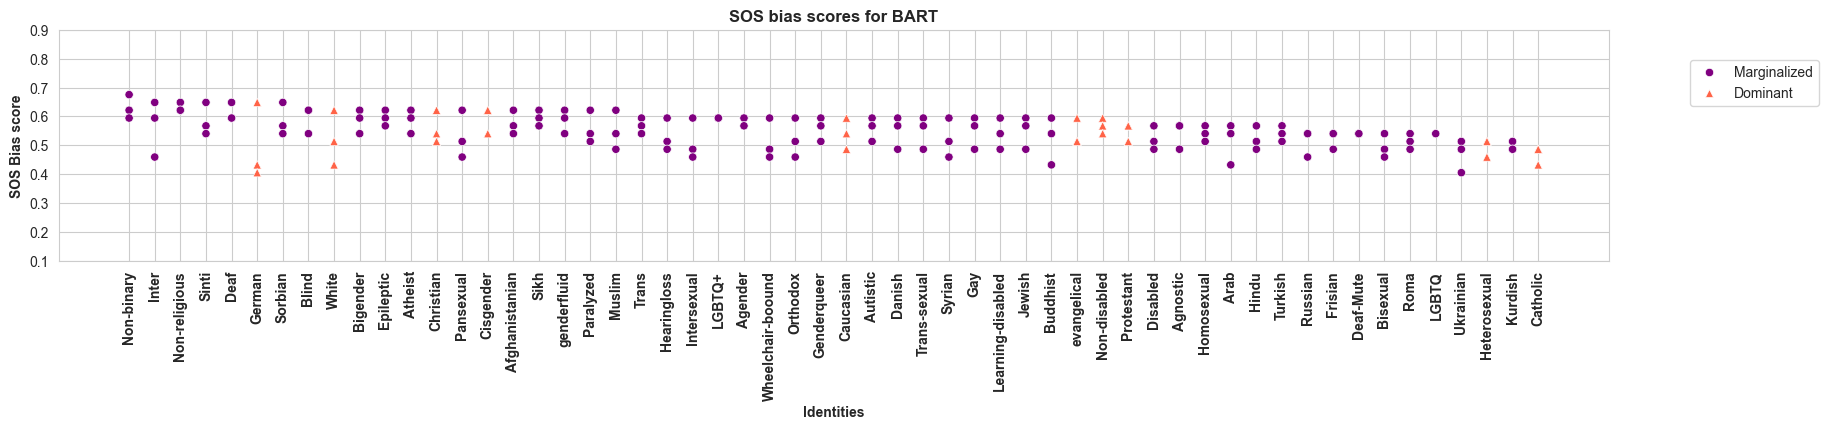

In [8]:
BART = display_identity_SOS_scores(BART_results_Masc, BART_results_Femm, BART_results_NB)
BART = BART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in BART.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}
fig1, axs1 = plt.subplots(figsize=(20, 3))
sns.scatterplot(data = BART, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs1, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs1.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs1.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs1.set_ylabel("SOS Bias score", fontweight="bold")
axs1.set_xlabel("Identities", fontweight="bold")
axs1.set_yticks(np.arange(0.1,1,0.1))
axs1.set_title("SOS bias scores for BART", fontweight='bold')
fig1.savefig('SOS bias scores for BART.png', bbox_inches='tight')

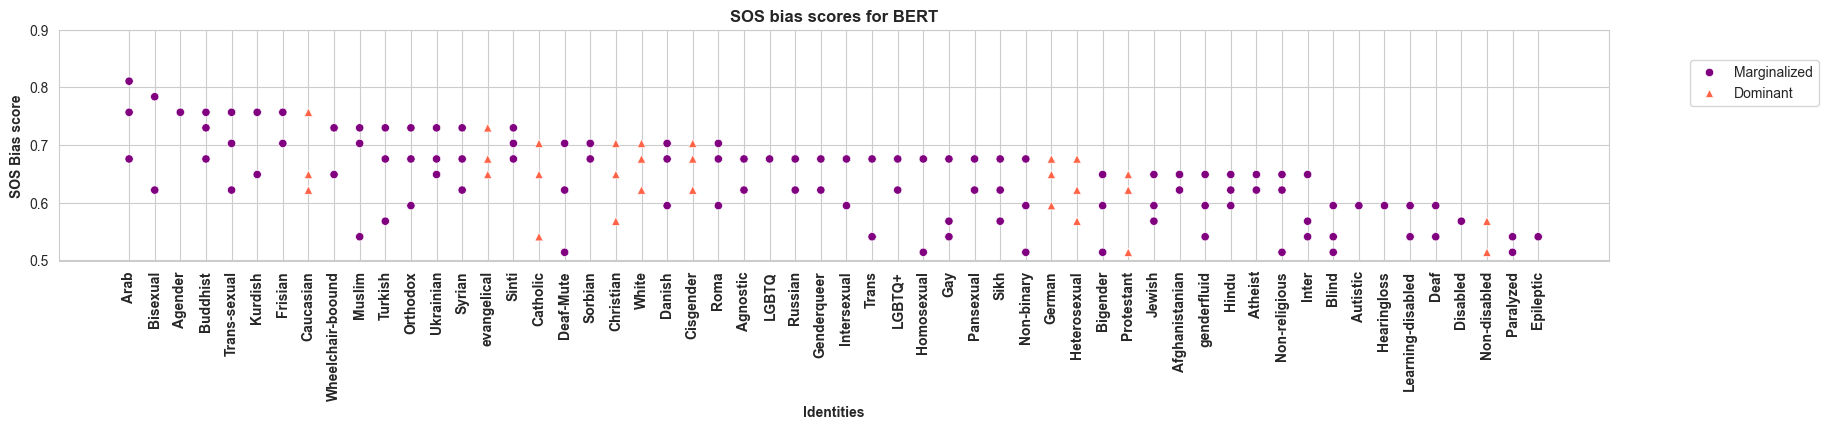

In [10]:
BERT = display_identity_SOS_scores(BERT_results_Masc, BERT_results_Femm, BERT_results_NB)
BERT = BERT[BERT["percentage_of_toxic_sentences"]>0.5].sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in BERT.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig3, axs3 = plt.subplots(figsize=(20, 3))
sns.scatterplot(data = BERT[BERT["percentage_of_toxic_sentences"]>0.5], x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs3, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for BERT", fontweight='bold')
fig3.savefig('SOS bias scores for BERT SOS bias Scores more than 0_5.png', bbox_inches='tight')

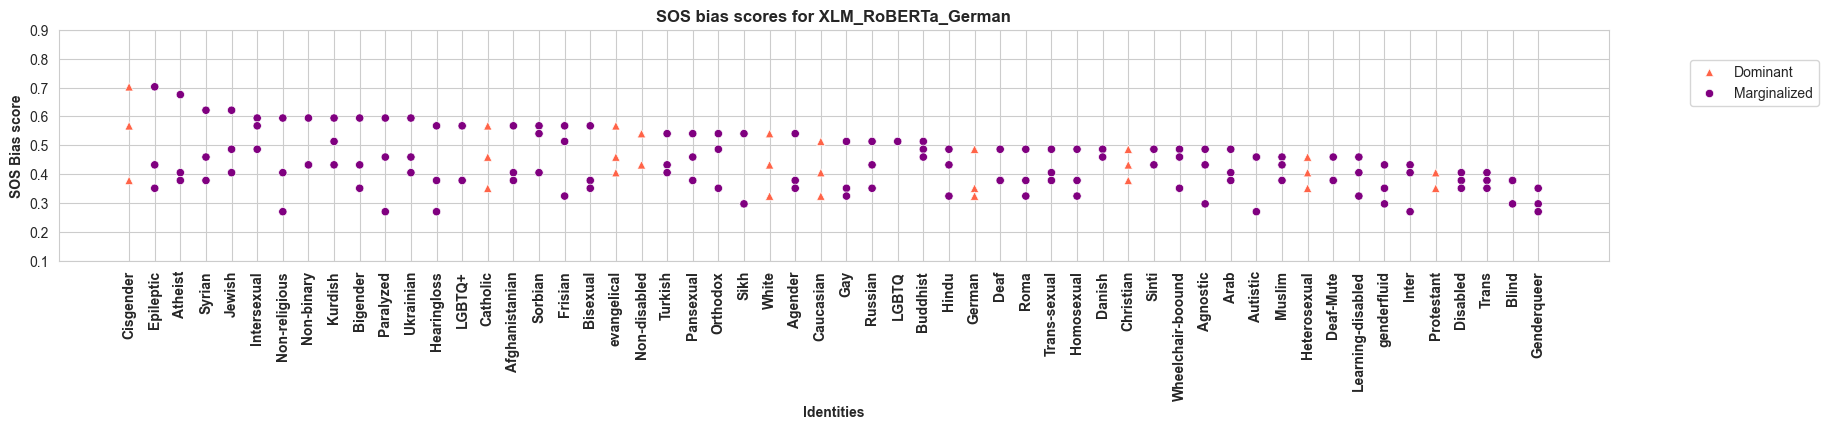

In [11]:
XLM_RoBERTa_German = display_identity_SOS_scores(XLM_RoBERTa_German_results_Masc, XLM_RoBERTa_German_results_Femm, XLM_RoBERTa_German_results_NB)
XLM_RoBERTa_German = XLM_RoBERTa_German.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in XLM_RoBERTa_German.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])
    
palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig2, axs2 = plt.subplots(figsize=(20, 3))
sns.scatterplot(data = XLM_RoBERTa_German, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", hue='group', ax=axs2, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs2.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs2.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs2.set_ylabel("SOS Bias score", fontweight="bold")
axs2.set_xlabel("Identities", fontweight="bold")
axs2.set_yticks(np.arange(0.1,1,0.1))
axs2.set_title("SOS bias scores for XLM_RoBERTa_German", fontweight='bold')
fig2.savefig('SOS bias scores for XLM_RoBERTa_German.png', bbox_inches='tight')

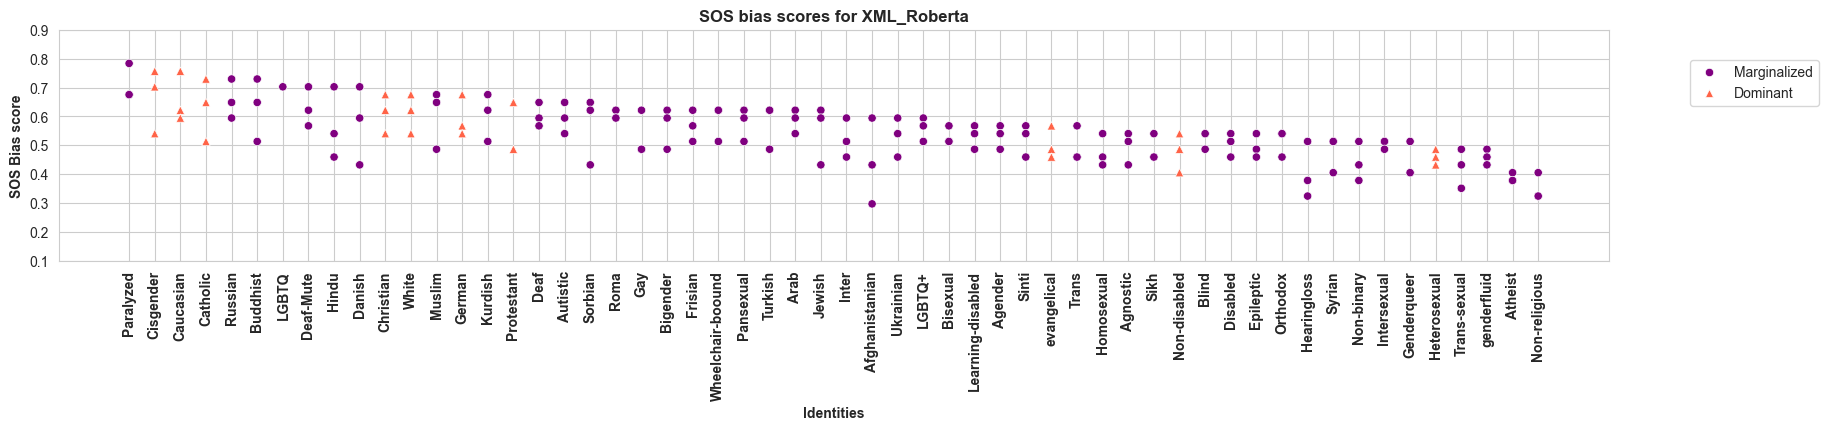

In [12]:
XML_Roberta = display_identity_SOS_scores(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB)
XML_Roberta = XML_Roberta.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in XML_Roberta.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig4, axs4 = plt.subplots(figsize=(20, 3))
sns.scatterplot(data = XML_Roberta, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs4, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs4.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs4.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs4.set_ylabel("SOS Bias score", fontweight="bold")
axs4.set_xlabel("Identities", fontweight="bold")
axs4.set_yticks(np.arange(0.1,1,0.1))
axs4.set_title("SOS bias scores for XML_Roberta", fontweight='bold')
fig4.savefig('SOS bias scores for XML_Roberta.png', bbox_inches='tight')

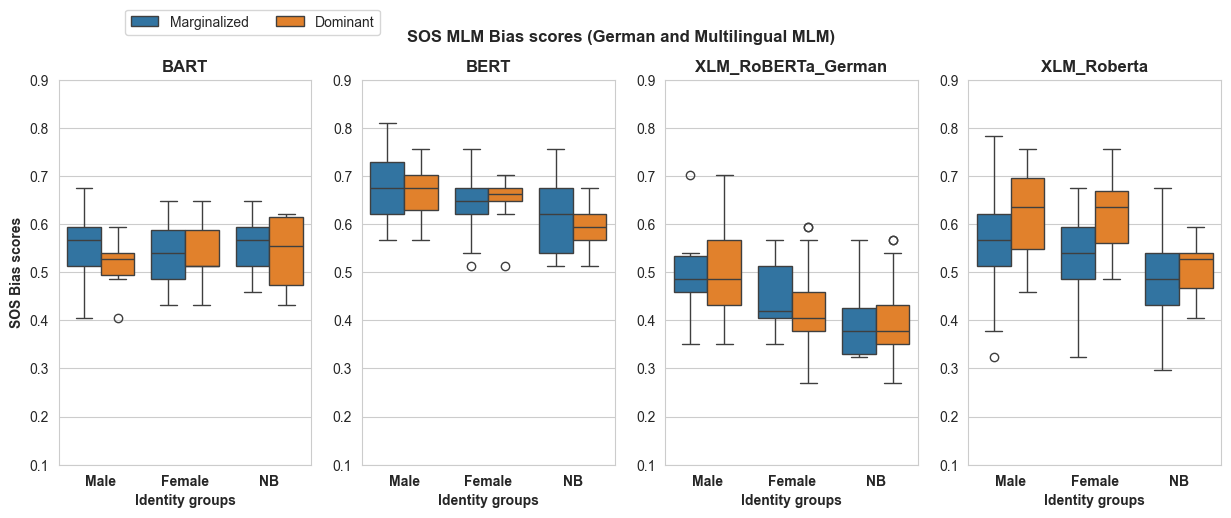

In [12]:
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle("SOS MLM Bias scores (German and Multilingual MLM)", fontweight="bold")

sns.boxplot(data=BART, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[0])
axs[0].set_title("BART", fontweight="bold")
axs[0].legend(bbox_to_anchor=(1.1, 0.4, 0.2, 0.8),ncol=3)
#axs[0].set_xticks("")
#axs[0].set(xlabel="")
axs[0].set_ylabel("SOS Bias scores", fontweight="bold")
#axs[0].get_legend().remove()
axs[0].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=BERT, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[1])
axs[1].set_title("BERT", fontweight="bold")
#axs[1].legend(bbox_to_anchor=(0.8, 0.7, 0.2, 0.8),ncol=3)
#axs[1].set(xlabel="")
axs[1].set(ylabel="")
#axs[1].set_xticks("")
axs[1].get_legend().remove()
axs[1].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=XLM_RoBERTa_German, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[2])
axs[2].set_title("XLM_RoBERTa_German", fontweight="bold")
#axs[2].legend(bbox_to_anchor=(0.2, -0.5, 0.2, 0.8),ncol=3)
axs[2].get_legend().remove()
axs[2].set(ylabel="")
axs[2].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=XML_Roberta, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[3])
axs[3].set_title("XLM_Roberta", fontweight="bold")
#axs[3].legend(bbox_to_anchor=(0.8, -1.1, 0.1, 0.8),ncol=3)
axs[3].set(ylabel="")
axs[3].get_legend().remove()
axs[3].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[3].set_yticks(np.arange(0.1,1,0.1))
axs[3].set_xlabel("Identity groups", fontweight="bold")


fig.savefig('Summarized_SOS_bias_scores_Germany_boxplot.png', bbox_inches='tight')

In [13]:
print("BART", BART.percentage_of_toxic_sentences.mean())
print("BERT", BERT.percentage_of_toxic_sentences.mean())
print("XLM_RoBERTa_German", XLM_RoBERTa_German.percentage_of_toxic_sentences.mean())
print("XML_Roberta", XML_Roberta.percentage_of_toxic_sentences.mean())


BART 0.5483555845001629
BERT 0.6434176111595467
XLM_RoBERTa_German 0.43796808857049824
XML_Roberta 0.5420058612829697


In [9]:
def plot_sos_bias_for_each_senstive_attribute(model_results_Masc, model_results_Femm, model_results_NB, model_name):
    fig, axs = plt.subplots(3,2, figsize=(10,15))
    
    palette = {"Dominant":"tomato", "Marginalized":"purple"}    
    #fig.suptitle("SOS AraAlBERT Bias scores (Arabic and multilingual AraAlBERT Egypt and Egyptian Arabic)", fontweight="bold")
    
    model = display_identity_SOS_scores(model_results_Masc, model_results_Femm, model_results_NB)
    
    model_sexual_orientation = model[model["bias_type"].isin(["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"])]
    model_sexual_orientation = model_sexual_orientation.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih1 = []
    for i, r in model_sexual_orientation.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih1.append(r["identity_in_english"].values[0])
    

    
    sns.scatterplot(data = model_sexual_orientation, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs[0,0], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[0,0].set_xticks(range(0, len(identityies_in_englsih1)),identityies_in_englsih1, rotation = 90, fontweight='bold')
    axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,0].set_xlabel("Identities", fontweight="bold")
    axs[0,0].set_yticks(np.arange(0.1,1,0.1))
    axs[0,0].get_legend().remove()
    axs[0,0].set_title("SOS bias scores for "+model_name+"_sexual_orientation", fontweight='bold')
    #fig1.savefig('SOS bias scores for AraAlBERT_sexual_orientation (Egypt).png', bbox_inches='tight')
    
    model_religion = model[model["bias_type"].isin(["Religion_Marginalized",
                                                           "Religion_Non_Marginalized"])]
    model_religion = model_religion.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih2 = []
    for i, r in model_religion.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih2.append(r["identity_in_english"].values[0])
   
    sns.scatterplot(data = model_religion, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs[0,1], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[0,1].set_xticks(range(0, len(identityies_in_englsih2)),identityies_in_englsih2, rotation = 90, fontweight='bold')
    axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,1].set_xlabel("Identities", fontweight="bold")
    axs[0,1].set_yticks(np.arange(0.1,1,0.1))
    axs[0,1].get_legend().remove()
    axs[0,1].set_title("SOS bias scores for "+model_name+"_religion", fontweight='bold')
    #fig2.savefig('SOS bias scores for AraAlBERT_religion (Egypt).png', bbox_inches='tight')
    
    model_race = model[model["bias_type"].isin(["Race_Marginalized",
                                                           "Race_Non_marginalized"])]
    model_race = model_race.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih3 = []
    for i, r in model_race.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih3.append(r["identity_in_english"].values[0])
    
    sns.scatterplot(data = model_race, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs[1,0], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[1,0].set_xticks(range(0, len(identityies_in_englsih3)),identityies_in_englsih3, rotation = 90, fontweight='bold')
    axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,0].set_xlabel("Identities", fontweight="bold")
    axs[1,0].set_yticks(np.arange(0.1,1,0.1))
    axs[1,0].get_legend().remove()
    axs[1,0].set_title("SOS bias scores for "+model_name+"_race", fontweight='bold')
    #fig3.savefig('SOS bias scores for AraAlBERT_race (Egypt).png', bbox_inches='tight')
    
    
    model_gender = model[model["bias_type"].isin(["Gender_Marginalized",
                                                           "Gender_Non_marginalized"])]
    model_gender = model_gender.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih4 = []
    for i, r in model_gender.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih4.append(r["identity_in_english"].values[0])
       
    sns.scatterplot(data = model_gender, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs[1,1], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[1,1].set_xticks(range(0, len(identityies_in_englsih4)),identityies_in_englsih4, rotation = 90, fontweight='bold')
    axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,1].set_xlabel("Identities", fontweight="bold")
    axs[1,1].set_yticks(np.arange(0.1,1,0.1))
    axs[1,1].get_legend().remove()
    axs[1,1].set_title("SOS bias scores for "+model_name+"_gender", fontweight='bold')
    #fig4.savefig('SOS bias scores for AraAlBERT_gender (Egypt).png', bbox_inches='tight')
    
    model_disability = model[model["bias_type"].isin(["Physical_ability_Marginalized",
                                                           "Physical_ability_Non_Marginalized"])]
    
    model_disability = model_disability.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih5 = []
    for i, r in model_disability.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih5.append(r["identity_in_english"].values[0])
       
    sns.scatterplot(data = model_disability, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs[2,0], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[2,0].set_xticks(range(0, len(identityies_in_englsih5)),identityies_in_englsih5, rotation = 90, fontweight='bold')
    axs[2,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,0].set_xlabel("Identities", fontweight="bold")
    axs[2,0].set_yticks(np.arange(0.1,1,0.1))
    axs[2,0].get_legend().remove()
    axs[2,0].set_title("SOS bias scores for "+model_name+"_disability", fontweight='bold')
    #fig5.savefig('SOS bias scores for AraAlBERT_disability (Egypt).png', bbox_inches='tight')
    
    model_refugees = model[model["bias_type"].isin(["Refugees_Marginalized",
                                                           "Refugees_Non_Marginalized"])]
    
    model_refugees = model_refugees.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih6 = []
    for i, r in model_refugees.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih6.append(r["identity_in_english"].values[0])
    
    
    sns.scatterplot(data = model_refugees, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs[2,1], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[2,1].set_xticks(range(0, len(identityies_in_englsih6)),identityies_in_englsih6, rotation = 90, fontweight='bold')
    axs[2,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,1].set_xlabel("Identities", fontweight="bold")
    axs[2,1].set_yticks(np.arange(0.1,1,0.1))
    axs[2,1].set_title("SOS bias scores for "+model_name+"_refugees", fontweight='bold')
    fig.tight_layout()
    fig.savefig('SOS bias scores for '+model_name+ '(Germany).png', bbox_inches='tight')


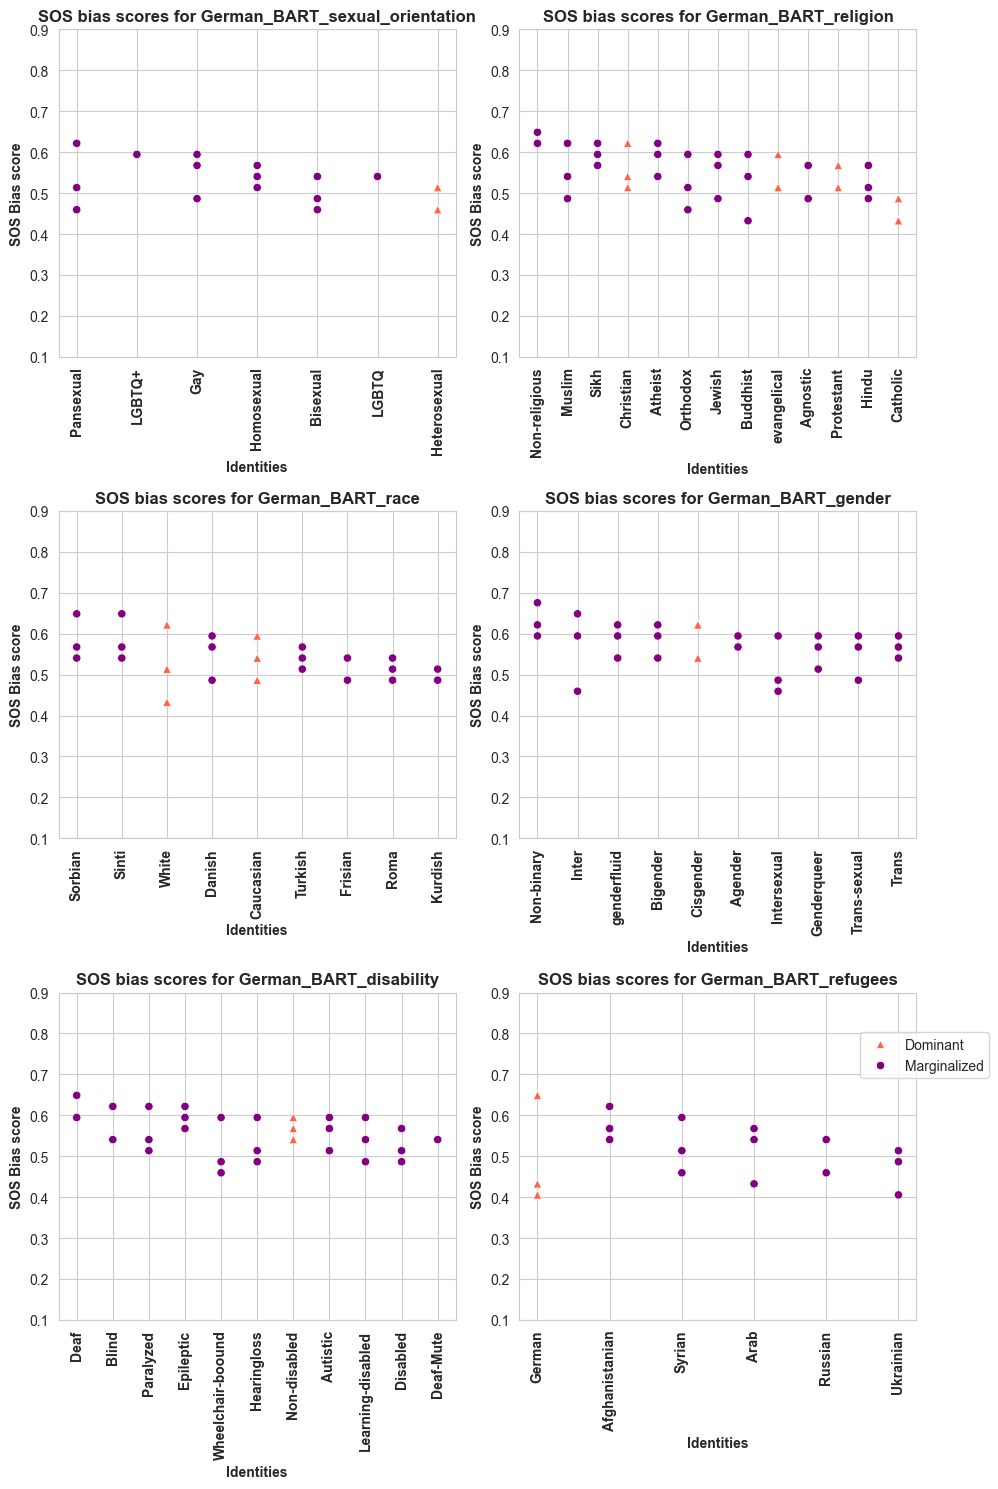

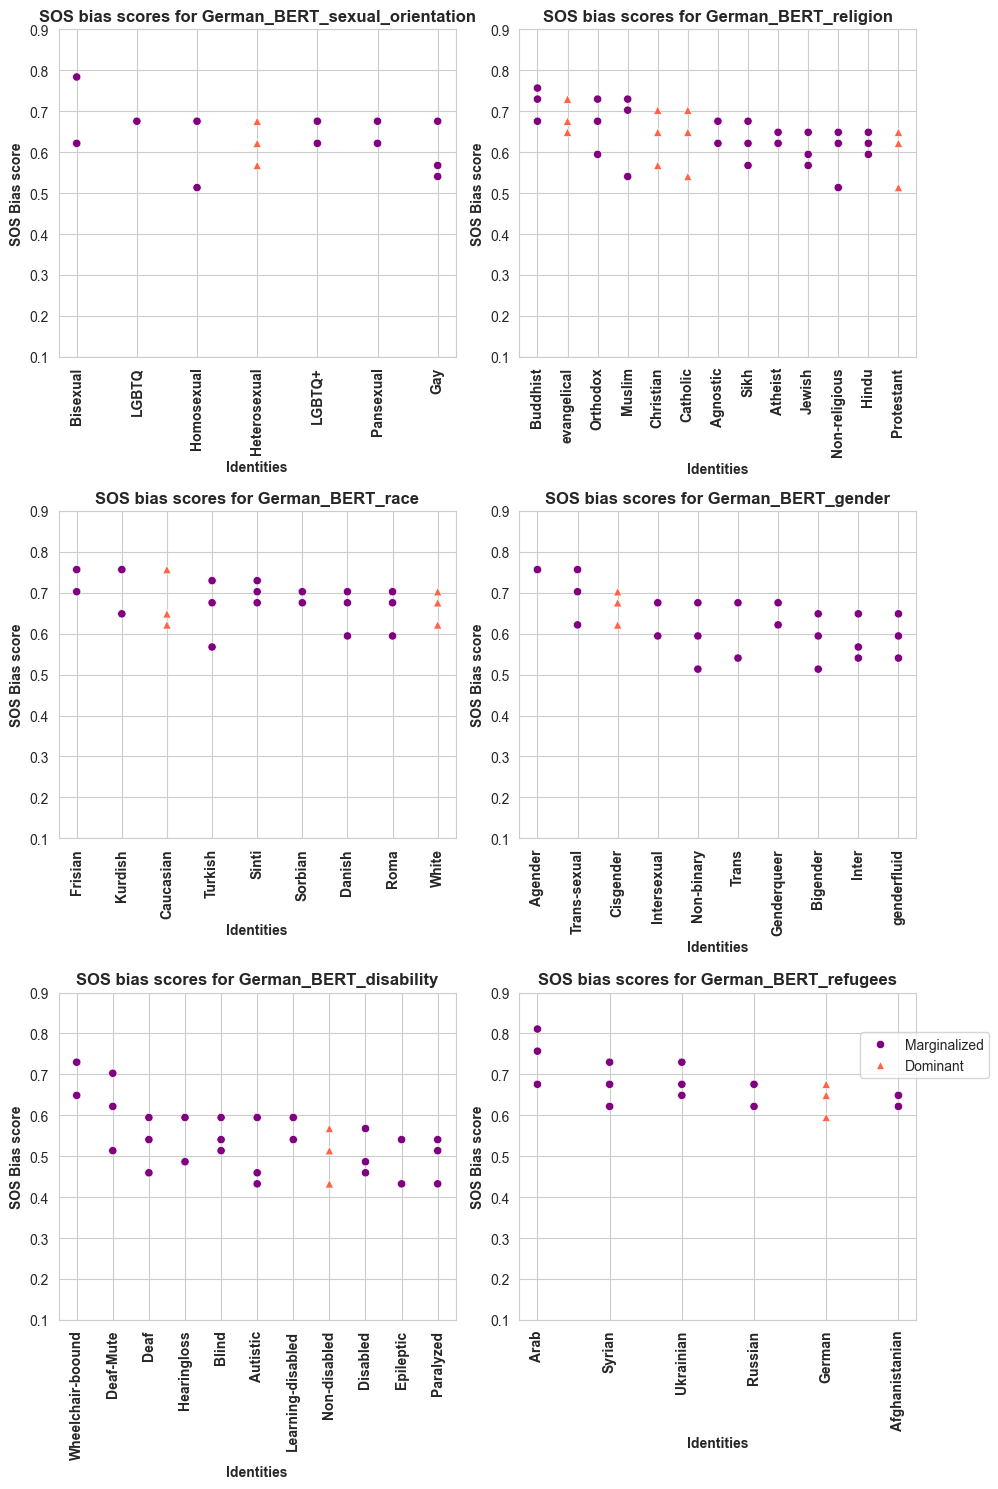

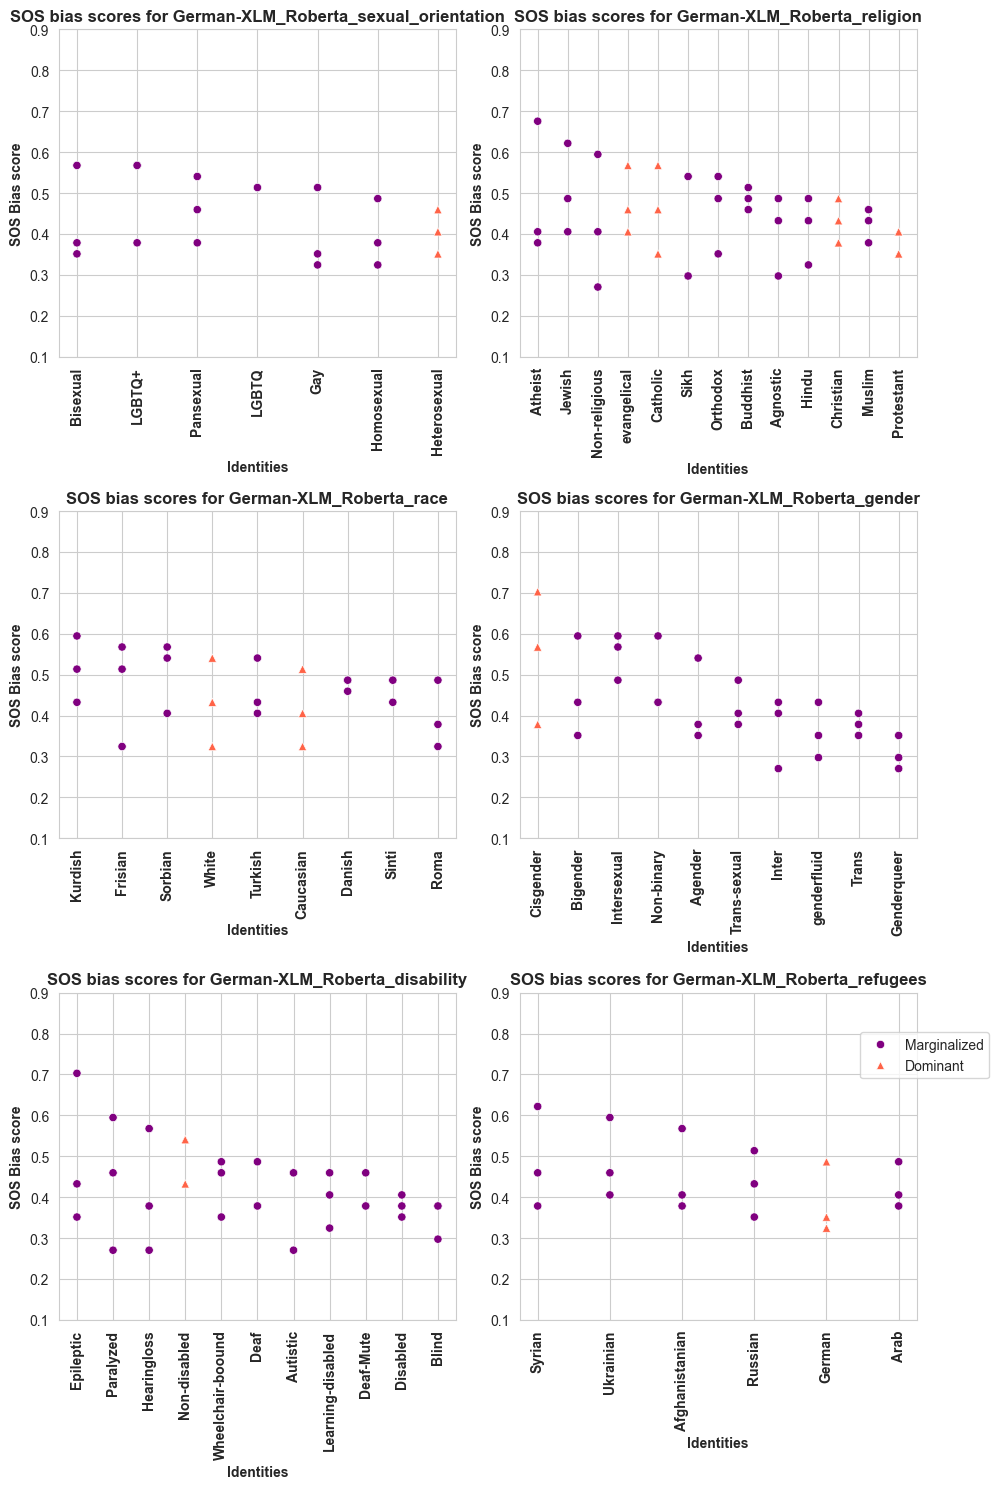

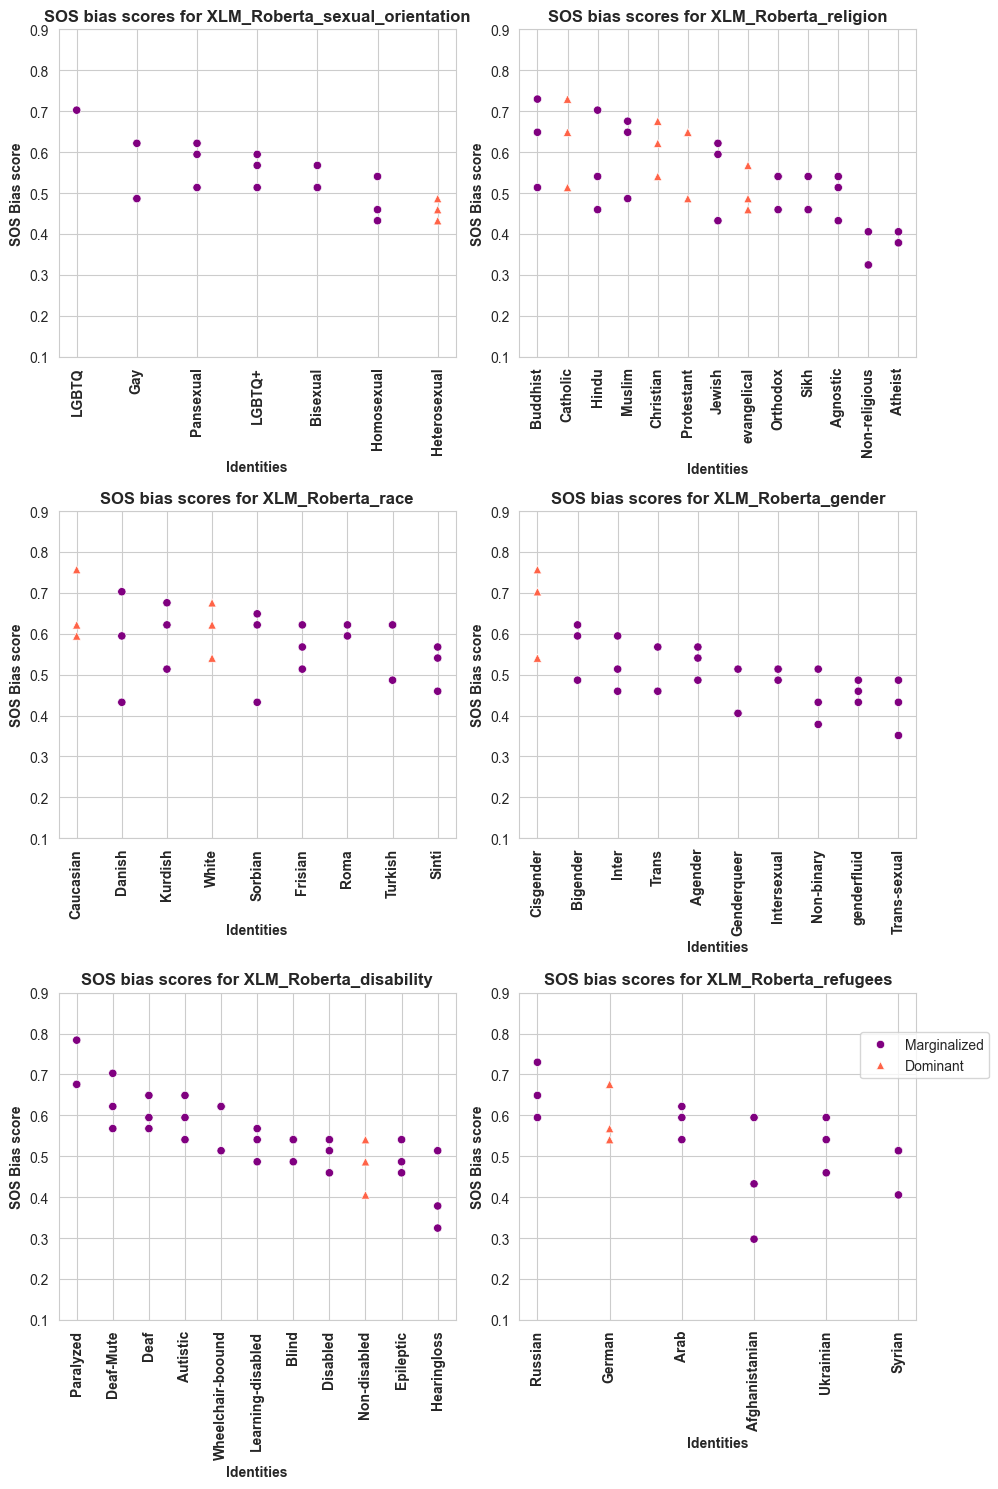

In [10]:
plot_sos_bias_for_each_senstive_attribute(BART_results_Masc, BART_results_Femm, BART_results_NB, "German_BART")
plot_sos_bias_for_each_senstive_attribute(BERT_results_Masc, BERT_results_Femm, BERT_results_NB, "German_BERT")
plot_sos_bias_for_each_senstive_attribute(XLM_RoBERTa_German_results_Masc, XLM_RoBERTa_German_results_Femm, XLM_RoBERTa_German_results_NB, "German-XLM_Roberta")
plot_sos_bias_for_each_senstive_attribute(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB, "XLM_Roberta")


## Refugees  analysis

In [21]:
BART

,identity,percentage_of_toxic_sentences,percentage_of_non_toxic_comment,bias_type,identity_in_english,group,gender
49,nicht-binärer,0.675676,0.324324,Gender_Marginalized,Non-binary,Marginalized,Masc
2,inter,0.648649,0.351351,Gender_Marginalized,Inter,Marginalized,Femm
56,nicht-religiöse,0.648649,0.351351,Religion_Marginalized,Non-religious,Marginalized,Femm
31,sintischer,0.648649,0.351351,Race_Marginalized,Sinti,Marginalized,Non-Binary
39,tauber,0.648649,0.351351,Physical_ability_Marginalized,Deaf,Marginalized,Non-Binary
...,...,...,...,...,...,...,...
21,katholischer,0.432432,0.567568,Religion_Non_Marginalized,Catholic,Dominant,Non-Binary
1,weiße,0.432432,0.567568,Race_Non_marginalized,White,Dominant,Femm
9,arabische,0.432432,0.567568,Refugees_Marginalized,Arab,Marginalized,Femm
11,ukrainischer,0.405405,0.594595,Refugees_Marginalized,Ukrainian,Marginalized,Masc


In [33]:
BART_Masc_refugees = BART[BART["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
BART_Masc_refugees = BART_Masc_refugees[BART_Masc_refugees["gender"]=="Masc"]

BART_Femm_refugees = BART[BART["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
BART_Femm_refugees = BART_Femm_refugees[BART_Femm_refugees["gender"] == "Femm"]

BART_NB_refugees = BART[BART["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
BART_NB_refugees = BART_NB_refugees[BART_NB_refugees["gender"] == "Non-Binary"]

<Axes: xlabel='identity_in_english', ylabel='percentage_of_toxic_sentences'>

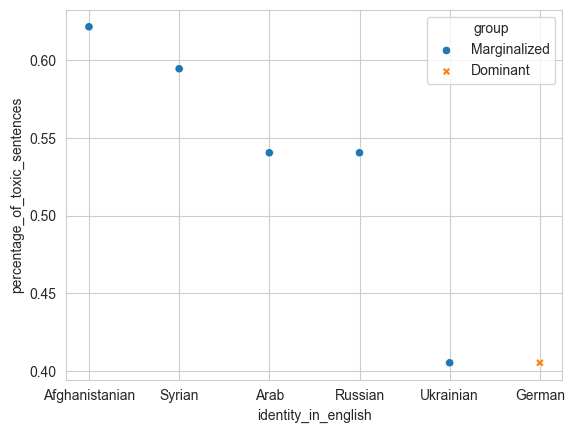

In [34]:
sns.scatterplot(BART_Masc_refugees,x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group")

<Axes: xlabel='identity_in_english', ylabel='percentage_of_toxic_sentences'>

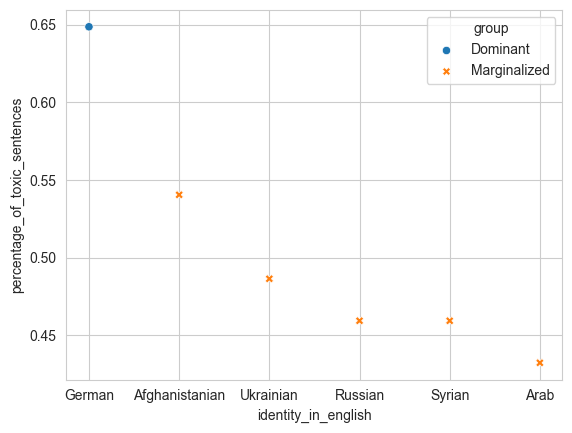

In [35]:
sns.scatterplot(BART_Femm_refugees,x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group")

<Axes: xlabel='identity_in_english', ylabel='percentage_of_toxic_sentences'>

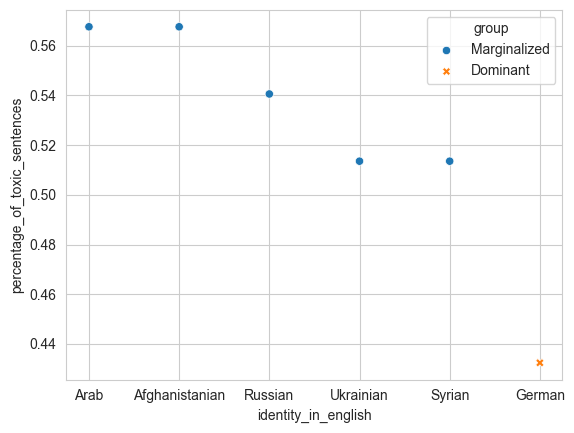

In [36]:
sns.scatterplot(BART_NB_refugees,x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group")

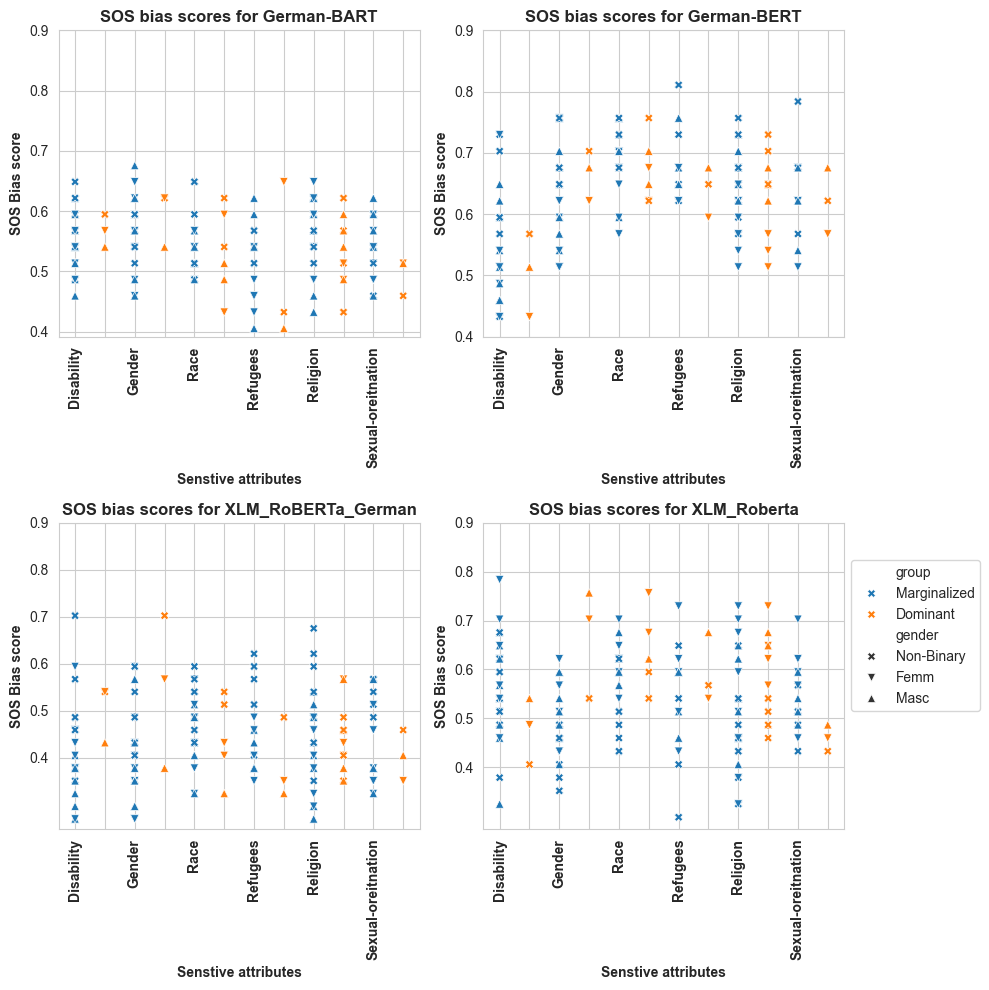

In [12]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

xlabels = ["Disability","", "Gender", '', "Race", "", "Refugees","", "Religion","", "Sexual-oreitnation",""]

BART_display = display_identity_SOS_scores(BART_results_Masc, BART_results_Femm, BART_results_NB)
BART_display["sens_attribute"] = BART_display["bias_type"].apply(lambda x:match_sens_attr(x))
BART_display["Model_Name"] = "German-BART"
BART_display = BART_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = BART_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[0,0],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[0,0].set_xticks(range(0, len(BART_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
axs[0,0].set_xlabel("Senstive attributes", fontweight="bold")
axs[0,0].set_yticks(np.arange(0.4,1,0.1))
axs[0,0].set_title("SOS bias scores for German-BART", fontweight='bold')
axs[0,0].get_legend().remove()
axs[0,0].set_title("SOS bias scores for German-BART", fontweight='bold')
    

BERT_display = display_identity_SOS_scores(BERT_results_Masc, BERT_results_Femm, BERT_results_NB)
BERT_display["sens_attribute"] = BERT_display["bias_type"].apply(lambda x:match_sens_attr(x))
BERT_display["Model_Name"] = "German-BERT"
BERT_display = BERT_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = BERT_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[0,1],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[0,1].set_xticks(range(0, len(BERT_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
axs[0,1].set_xlabel("Senstive attributes", fontweight="bold")
axs[0,1].set_yticks(np.arange(0.4,1,0.1))
axs[0,1].set_title("SOS bias scores for German-BERT", fontweight='bold')
axs[0,1].get_legend().remove()
axs[0,1].set_title("SOS bias scores for German-BERT", fontweight='bold')


XLM_RoBERTa_German_display = display_identity_SOS_scores(XLM_RoBERTa_German_results_Masc, XLM_RoBERTa_German_results_Femm, XLM_RoBERTa_German_results_NB)
XLM_RoBERTa_German_display["sens_attribute"] = XLM_RoBERTa_German_display["bias_type"].apply(lambda x:match_sens_attr(x))
XLM_RoBERTa_German_display["Model_Name"] = "German-XLM_RoBERTa"
XLM_RoBERTa_German_display = XLM_RoBERTa_German_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = XLM_RoBERTa_German_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[1,0],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[1,0].set_xticks(range(0, len(XLM_RoBERTa_German_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
axs[1,0].set_xlabel("Senstive attributes", fontweight="bold")
axs[1,0].set_yticks(np.arange(0.4,1,0.1))
axs[1,0].set_title("SOS bias scores for XLM_RoBERTa_German", fontweight='bold')
axs[1,0].get_legend().remove()
axs[1,0].set_title("SOS bias scores for XLM_RoBERTa_German", fontweight='bold')

XML_Roberta_display = display_identity_SOS_scores(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB)
XML_Roberta_display["sens_attribute"] = XML_Roberta_display["bias_type"].apply(lambda x:match_sens_attr(x))
XML_Roberta_display["Model_Name"] = "XLM_RoBERTa"
XML_Roberta_display = XML_Roberta_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = XML_Roberta_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[1,1],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[1,1].set_xticks(range(0, len(XML_Roberta_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
axs[1,1].set_xlabel("Senstive attributes", fontweight="bold")
axs[1,1].set_yticks(np.arange(0.4,1,0.1))
axs[1,1].set_title("SOS bias scores for XLM_Roberta", fontweight='bold')
#axs[2,1].get_legend().remove()
axs[1,1].set_title("SOS bias scores for XLM_Roberta", fontweight='bold')  

    
fig.tight_layout()
fig.savefig('SOS bias scores for distribution of senstive attribues in different models in Germany.png', bbox_inches='tight')


In [23]:
All_model_dispplays

,identity,percentage_of_toxic_sentences,percentage_of_non_toxic_comment,bias_type,identity_in_english,group,gender,sens_attribute,Model_Name,sens_attribute2
12,nicht-behinderter,0.540541,0.459459,Physical_ability_Non_Marginalized,Non-disabled,Dominant,Masc,disability (N),BART,disability_BART_Dominant
27,nicht-behinderte,0.567568,0.432432,Physical_ability_Non_Marginalized,Non-disabled,Dominant,Femm,disability (N),BART,disability_BART_Dominant
50,nicht-behinderter,0.594595,0.405405,Physical_ability_Non_Marginalized,Non-disabled,Dominant,Non-Binary,disability (N),BART,disability_BART_Dominant
37,epileptische,0.567568,0.432432,Physical_ability_Marginalized,Epileptic,Marginalized,Femm,disability (M),BART,disability_BART_Marginalized
3,rollstuhl-gebundener,0.459459,0.540541,Physical_ability_Marginalized,Wheelchair-boound,Marginalized,Masc,disability (M),BART,disability_BART_Marginalized
...,...,...,...,...,...,...,...,...,...,...
14,pansexueller,0.540541,0.459459,Sexual_orientation_Marginalized,Pansexual,Marginalized,Non-Binary,sexual orientation (M),XLM_RoBERTa,sexual orientation_XLM_RoBERTa_Marginalized
43,schwuler,0.324324,0.675676,Sexual_orientation_Marginalized,Gay,Marginalized,Masc,sexual orientation (M),XLM_RoBERTa,sexual orientation_XLM_RoBERTa_Marginalized
48,lgbtqia+,0.567568,0.432432,Sexual_orientation_Marginalized,LGBTQ+,Marginalized,Masc,sexual orientation (M),XLM_RoBERTa,sexual orientation_XLM_RoBERTa_Marginalized
55,pansexueller,0.378378,0.621622,Sexual_orientation_Marginalized,Pansexual,Marginalized,Masc,sexual orientation (M),XLM_RoBERTa,sexual orientation_XLM_RoBERTa_Marginalized


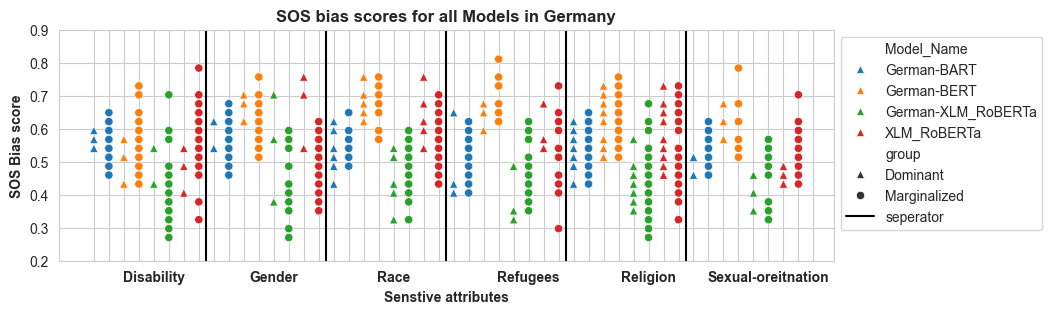

In [13]:
All_model_dispplays = pd.concat([BART_display, BERT_display, XLM_RoBERTa_German_display, XML_Roberta_display])

def sens_attribute_name(x):
    att= ""
    if x in ["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"]:
            att = "sexual orientation"
        
    elif x in ["Religion_Marginalized", "Religion_Non_Marginalized"]:
            att = "religion"
        
    elif x in ["Race_Marginalized","Race_Non_marginalized"]:
            att = "race"
            
    elif x in ["Physical_ability_Marginalized","Physical_ability_Non_Marginalized"]:
            att = "disability"
            
    elif x in ["Refugees_Marginalized","Refugees_Non_Marginalized"]:
            att = "refugees"
            
    elif x in ["Gender_Marginalized","Gender_Non_marginalized"]:
            att = "gender"
    return att

xlabels = ["","","","","Disability","","","",
           "","","","","Gender","","","",
           "","","","","Race","","","","",
           "","","","","Refugees","","","",
           "","","","","Religion","","","",
           "","","","","Sexual-oreitnation","","",""]

All_model_dispplays["sens_attribute2"] = All_model_dispplays.apply(lambda x:sens_attribute_name(x["bias_type"])+"_"+x["Model_Name"]+"_"+x["group"], axis=1)

All_model_dispplays = All_model_dispplays.sort_values(by=["sens_attribute2"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(10, 3))
sns.scatterplot(data = All_model_dispplays, x='sens_attribute2', hue='Model_Name', y='percentage_of_toxic_sentences', style = 'group', ax=axs7, markers={'Marginalized':"o", 'Dominant':'^'})
plt.axvline(7.5,color='black', label='seperator')
plt.axvline(15.5,color='black')
plt.axvline(23.5,color='black')
plt.axvline(31.5,color='black')
plt.axvline(39.5,color='black')
axs7.set_xticks(range(0, len(xlabels)),xlabels, rotation = 0, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.2, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.2,1,0.1))
axs7.set_title("SOS bias scores for all Models in Germany", fontweight='bold')
#axs7.get_legend().remove()
plt.show()
fig7.savefig('SOS bias scores for all models displays senstive attribues.png', bbox_inches='tight')

In [14]:
All_model_dispplays_disability = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["disability (M)", "disability (N)"])]

All_model_dispplays_gender = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["gender (M)", "gender (N)"])]

All_model_dispplays_race = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["race (M)", "race (N)"])]

All_model_dispplays_refugees = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["refugees (M)", "refugees (N)"])]

All_model_dispplays_religion = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["religion (M)", "religion (N)"])]

All_model_dispplays_sexual_orientation = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["sexual orientation (M)", "sexual orientation (N)"])]

In [15]:
mar_var = []
mar_dom = []

mar_var.append(All_model_dispplays_disability[All_model_dispplays_disability["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_gender[All_model_dispplays_gender["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_race[All_model_dispplays_race["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_refugees[All_model_dispplays_refugees["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_religion[All_model_dispplays_religion["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_sexual_orientation[All_model_dispplays_sexual_orientation["group"] == "Dominant"].percentage_of_toxic_sentences.var())

In [16]:
mar_mar = []
mar_dom = []

mar_dom.append(All_model_dispplays_disability[All_model_dispplays_disability["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_gender[All_model_dispplays_gender["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_race[All_model_dispplays_race["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_refugees[All_model_dispplays_refugees["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_religion[All_model_dispplays_religion["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_sexual_orientation[All_model_dispplays_sexual_orientation["group"] == "Dominant"].percentage_of_toxic_sentences.var())

mar_mar.append(All_model_dispplays_disability[All_model_dispplays_disability["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_gender[All_model_dispplays_gender["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_race[All_model_dispplays_race["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_refugees[All_model_dispplays_refugees["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_religion[All_model_dispplays_religion["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_sexual_orientation[All_model_dispplays_sexual_orientation["group"] == "Marginalized"].percentage_of_toxic_sentences.var())

scipy.stats.wilcoxon(mar_mar, mar_dom)

WilcoxonResult(statistic=9.0, pvalue=0.84375)

In [17]:
np.mean(mar_mar), np.mean(mar_dom)

(0.011440061571108773, 0.010557329089812773)

## refugees analysis for all models

In [42]:
All_model_dispplays.columns

Index(['identity', 'percentage_of_toxic_sentences',
       'percentage_of_non_toxic_comment', 'bias_type', 'identity_in_english',
       'group', 'gender', 'sens_attribute', 'Model_Name', 'sens_attribute2'],
      dtype='object')

In [43]:
All_model_dispplays_Masc_refugees = All_model_dispplays[All_model_dispplays["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
All_model_dispplays_Masc_refugees = All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["gender"]=="Masc"]

All_model_dispplays_Femm_refugees = All_model_dispplays[All_model_dispplays["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
All_model_dispplays_Femm_refugees = All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["gender"] == "Femm"]

All_model_dispplays_NB_refugees = All_model_dispplays[All_model_dispplays["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
All_model_dispplays_NB_refugees = All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["gender"] == "Non-Binary"]

In [75]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="German"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="German"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="German"].percentage_of_toxic_sentences.mean())

Masc 0.5202702702702703
Femm 0.5337837837837838
NB 0.5337837837837838


In [76]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Arab"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Arab"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Arab"].percentage_of_toxic_sentences.mean())

Masc 0.5675675675675677
Femm 0.5540540540540541
NB 0.5810810810810811


In [77]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Afghanistanian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Afghanistanian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Afghanistanian"].percentage_of_toxic_sentences.mean())

Masc 0.5608108108108109
Femm 0.5
NB 0.5202702702702703


In [80]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Syrian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Syrian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Syrian"].percentage_of_toxic_sentences.mean())

Masc 0.5405405405405406
Femm 0.5135135135135135
NB 0.5675675675675675


In [78]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Russian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Russian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Russian"].percentage_of_toxic_sentences.mean())

Masc 0.5608108108108109
Femm 0.5540540540540541
NB 0.5810810810810811


In [79]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Ukrainian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Ukrainian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Ukrainian"].percentage_of_toxic_sentences.mean())

Masc 0.49324324324324326
Femm 0.5405405405405406
NB 0.5945945945945945


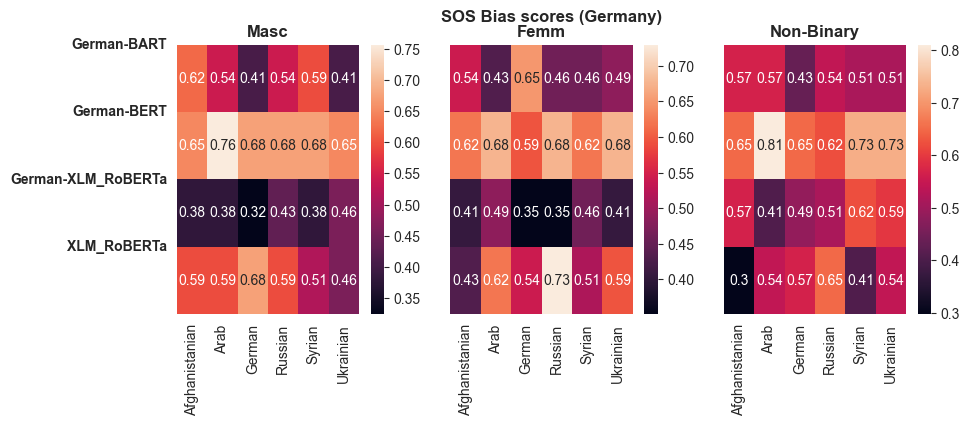

In [81]:
fig, axs = plt.subplots(1,3, figsize=(10, 3.5))
fig.suptitle("SOS Bias scores (Germany)", fontweight="bold")

#modelnames = ["German_BERT", "German_BART", "XLM_RoBERTa_German", "XLM_Roberta_Multilingual"]

marginalized_masc = All_model_dispplays_Masc_refugees.pivot(columns='identity_in_english', index="Model_Name", values="percentage_of_toxic_sentences")
sns.heatmap(marginalized_masc, annot=True, ax = axs[0], xticklabels=True, yticklabels=True)
axs[0].set_title("Masc", fontweight="bold")
axs[0].set_yticks(range(0,4), All_model_dispplays_Masc_refugees.Model_Name.unique().tolist(), fontweight="bold")
axs[0].set(xlabel="")
axs[0].set(ylabel="")

marginalized_femm = All_model_dispplays_Femm_refugees.pivot(columns='identity_in_english', index="Model_Name", values="percentage_of_toxic_sentences")
sns.heatmap(marginalized_femm, annot=True,  ax =axs[1], xticklabels=True, yticklabels=False)
axs[1].set(xlabel="")
axs[1].set(ylabel="")
axs[1].set_title("Femm", fontweight="bold")

marginalized_NB = All_model_dispplays_NB_refugees.pivot(columns='identity_in_english', index="Model_Name", values="percentage_of_toxic_sentences")
sns.heatmap(marginalized_NB, annot=True,   ax=axs[2], xticklabels=True, yticklabels=False)
axs[2].set(xlabel="")
axs[2].set(ylabel="")
axs[2].set_title("Non-Binary", fontweight="bold")
fig.savefig('SOS bias scores for different gender refugees.png', bbox_inches='tight')

## Average All Models

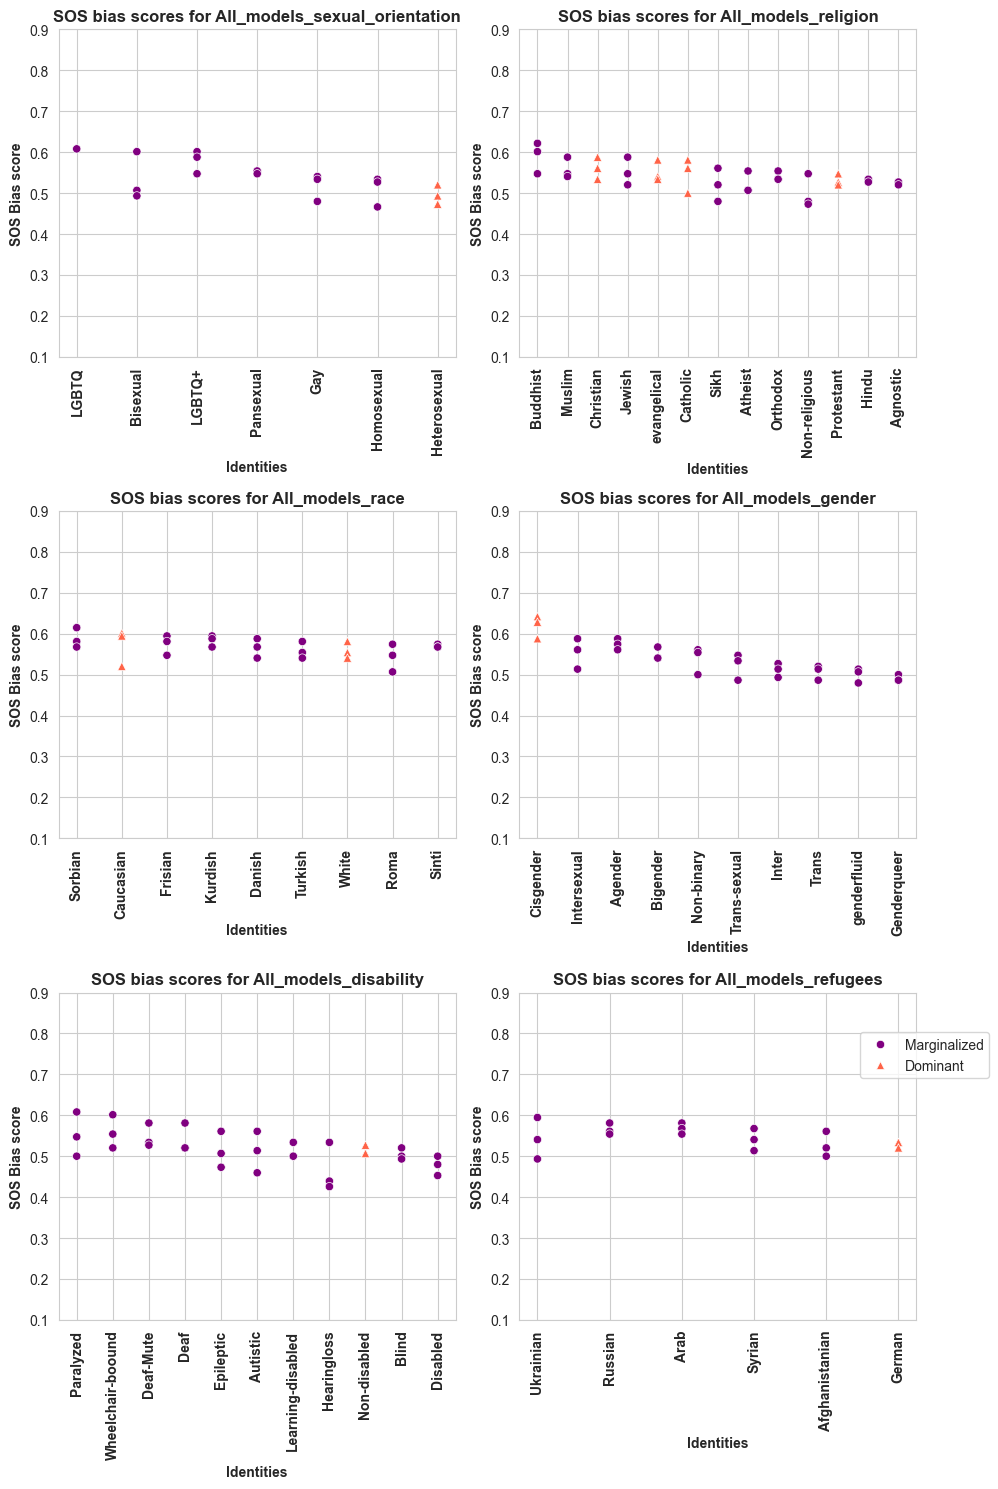

In [16]:
All_models_MASC = pd.concat([BART_results_Masc, BERT_results_Masc, XLM_RoBERTa_German_results_Masc, XML_Roberta_results_Masc])

All_models_Femm = pd.concat([BART_results_Femm, BERT_results_Femm, XLM_RoBERTa_German_results_Femm, XML_Roberta_results_Femm])

All_models_NB = pd.concat([BART_results_NB, BERT_results_NB, XLM_RoBERTa_German_results_NB, XML_Roberta_results_NB])

plot_sos_bias_for_each_senstive_attribute(All_models_MASC, All_models_Femm, All_models_NB, "All_models")

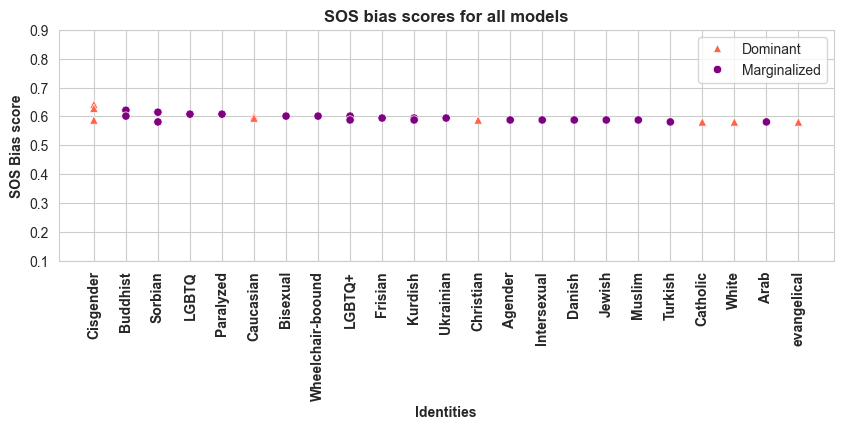

In [20]:
all_models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
all_models = all_models.sort_values(by="percentage_of_toxic_sentences", ascending=False)
all_models = all_models.head(30)

identityies_in_englsih = []
for i, r in all_models.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig4, axs4 = plt.subplots(figsize=(10, 3))
sns.scatterplot(data = all_models, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs4, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs4.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs4.legend(bbox_to_anchor=(0.8, 0.2, 0.2, 0.8),ncol=1)
axs4.set_ylabel("SOS Bias score", fontweight="bold")
axs4.set_xlabel("Identities", fontweight="bold")
axs4.set_yticks(np.arange(0.1,1,0.1))
axs4.set_title("SOS bias scores for all models", fontweight='bold')
fig4.savefig('SOS bias scores for average All models.png', bbox_inches='tight')

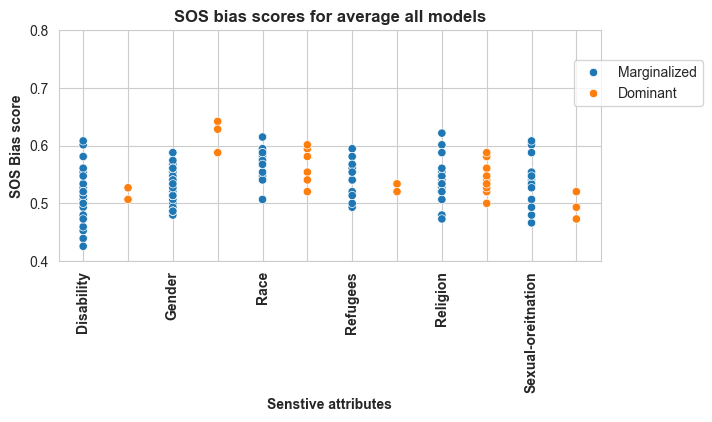

In [39]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
xlabels = ["Disability","", "Gender", '', "Race", "", "Refugees","", "Religion","", "Sexual-oreitnation",""]

All_Models["sens_attribute"] = All_Models["bias_type"].apply(lambda x:match_sens_attr(x))
All_Models = All_Models.sort_values(by=["sens_attribute"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(7, 3))
sns.scatterplot(data = All_Models, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', ax=axs7, markers={'Masc':'^', 'Femm':"v", 'Non-Binary':"X"})
axs7.set_xticks(range(0, len(All_Models["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.4,0.9,0.1))
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
#axs7.get_legend().remove()
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
plt.show()
fig7.savefig('SOS bias scores for average All_Models senstive attribues.png', bbox_inches='tight')

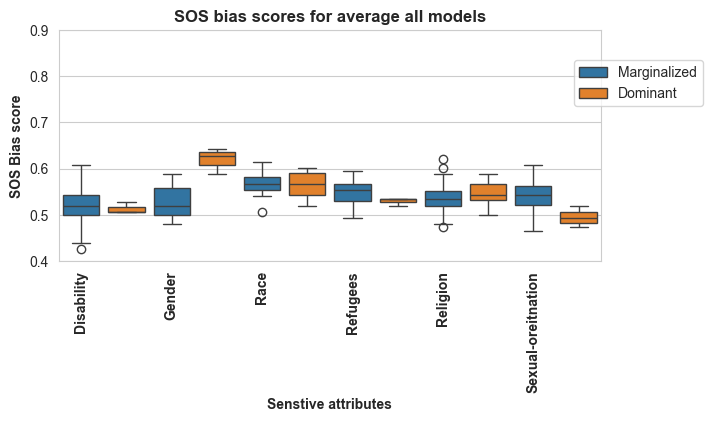

In [38]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
xlabels = ["Disability","", "Gender", '', "Race", "", "Refugees","", "Religion","", "Sexual-oreitnation",""]

All_Models["sens_attribute"] = All_Models["bias_type"].apply(lambda x:match_sens_attr(x))
All_Models = All_Models.sort_values(by=["sens_attribute"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(7, 3))
sns.boxplot(data = All_Models, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', ax=axs7)
axs7.set_xticks(range(0, len(All_Models["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.4,1,0.1))
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
plt.show()
#fig7.savefig('SOS bias scores for average All_Models senstive attribues.png', bbox_inches='tight')